German Traffic Sign Recognition Benchmark (GTSRB)
=================================================
---
Introduction au Deep Learning  (IDLE) - S. Aria, E. Maldonado, JL. Parouty - CNRS/SARI/DEVLOG - 2020

## Episode 3 : Tracking and visualizing

Our main steps:
 - Monitoring and understanding our model training
 - Analyze the results 
 - Improving our model
 - Add recovery points


## 1/ Import and init

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
from importlib import reload

import idle.pwk as ooo

ooo.init()

IDLE 2020 - Practical Work Module
  Version            : 0.1.1
  Run time           : Monday 6 January 2020, 15:56:03
  Matplotlib style   : idle/talk.mplstyle
  TensorFlow version : 2.0.0
  Keras version      : 2.2.4-tf


## 2/ Reload dataset
Dataset is one of the saved dataset: RGB25, RGB35, L25, L35, etc.  
First of all, we're going to use the dataset : **L25**  
(with a GPU, it only takes 35'' compared to more than 5' with a CPU !)

In [3]:
%%time

dataset ='L25'
img_lx  = 25
img_ly  = 25
img_lz  = 1

# ---- Read dataset
x_train = np.load('./data/{}/x_train.npy'.format(dataset))
y_train = np.load('./data/{}/y_train.npy'.format(dataset))

x_test  = np.load('./data/{}/x_test.npy'.format(dataset))
y_test  = np.load('./data/{}/y_test.npy'.format(dataset))

# ---- Reshape data
x_train = x_train.reshape( x_train.shape[0], img_lx, img_ly, img_lz)
x_test  = x_test.reshape(  x_test.shape[0],  img_lx, img_ly, img_lz)

input_shape = (img_lx, img_ly, img_lz)

print("Dataset loaded, size={:.1f} Mo\n".format(ooo.get_directory_size('./data/'+dataset)))

Dataset loaded, size=247.6 Mo

CPU times: user 0 ns, sys: 328 ms, total: 328 ms
Wall time: 342 ms


## 3/ Have a look to the dataset
Note: Data must be reshape for matplotlib

x_train :  (39209, 25, 25, 1)
y_train :  (39209,)
x_test  :  (12630, 25, 25, 1)
y_test  :  (12630,)


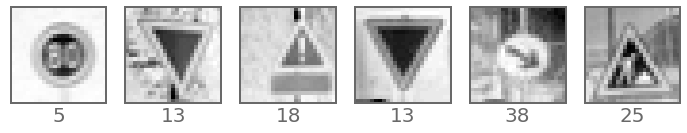

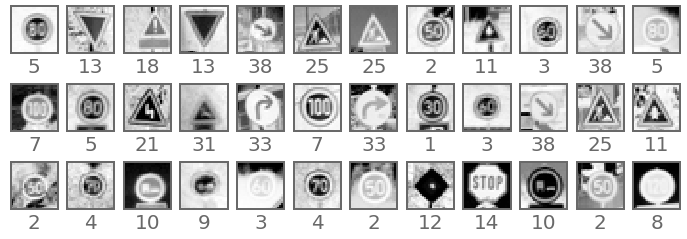

In [4]:
print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test  : ", x_test.shape)
print("y_test  : ", y_test.shape)

if img_lz>1:
    ooo.plot_images(x_train.reshape(-1,img_lx,img_ly,img_lz), y_train, range(6),  columns=3,  x_size=4, y_size=3)
    ooo.plot_images(x_train.reshape(-1,img_lx,img_ly,img_lz), y_train, range(36), columns=12, x_size=1, y_size=1)
else:
    ooo.plot_images(x_train.reshape(-1,img_lx,img_ly), y_train, range(6),  columns=6,  x_size=2, y_size=2)
    ooo.plot_images(x_train.reshape(-1,img_lx,img_ly), y_train, range(36), columns=12, x_size=1, y_size=1)

## 4/ Create model

In [12]:
batch_size  =  128
num_classes =  43
epochs      =  5

In [49]:
model = keras.models.Sequential()
model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(img_lx, img_ly, img_lz)))
model.add( keras.layers.MaxPooling2D((2, 2)))
model.add( keras.layers.MaxPooling2D((2, 2)))
# model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
# model.add( keras.layers.MaxPooling2D((2, 2)))
model.add( keras.layers.Flatten()) 
model.add( keras.layers.Dense(2400, activation='relu'))
# model.add( keras.layers.Dense(500, activation='relu'))
model.add( keras.layers.Dense(500, activation='relu'))
model.add( keras.layers.Dense(43, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 23, 23, 96)        960       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 11, 11, 96)        0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 5, 5, 96)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 2400)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 2400)              5762400   
_________________________________________________________________
dense_32 (Dense)             (None, 500)               1200500   
_________________________________________________________________
dense_33 (Dense)             (None, 43)              

## 5/ Add callbacks
Nous allons ajouter 2 callbacks :  
 - **TensorBoard**  
Training logs, which can be visualised with Tensorboard.  
`#tensorboard --logdir ./run/logs`  
 - model backup

In [52]:
# reload(ooo)
# ---- Callback for tensorboard
log_dir="./run/logs/" + ooo.tag_now()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

## 5/ Run model

In [51]:
%%time

history = model.fit(  x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_test, y_test),
                      callbacks=[tensorboard_callback] )

Train on 39209 samples, validate on 12630 samples
Epoch 1/5
39209/39209 [==============================] - 23s 586us/sample - loss: 1.4107 - accuracy: 0.6116 - val_loss: 0.7740 - val_accuracy: 0.8112
Epoch 2/5
39209/39209 [==============================] - 25s 632us/sample - loss: 0.3571 - accuracy: 0.8982 - val_loss: 0.6292 - val_accuracy: 0.8446
Epoch 3/5
39209/39209 [==============================] - 25s 643us/sample - loss: 0.1988 - accuracy: 0.9445 - val_loss: 0.5845 - val_accuracy: 0.8658
Epoch 4/5
39209/39209 [==============================] - 25s 644us/sample - loss: 0.1316 - accuracy: 0.9641 - val_loss: 0.5571 - val_accuracy: 0.8779
Epoch 5/5
39209/39209 [==============================] - 28s 704us/sample - loss: 0.1001 - accuracy: 0.9724 - val_loss: 0.5844 - val_accuracy: 0.8629
CPU times: user 12min 44s, sys: 39.9 s, total: 13min 24s
Wall time: 2min 5s


## 6/ Evaluation

In [15]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.4795
Test accuracy  : 0.8982


## 7/ History
The return of model.fit() returns us the learning history

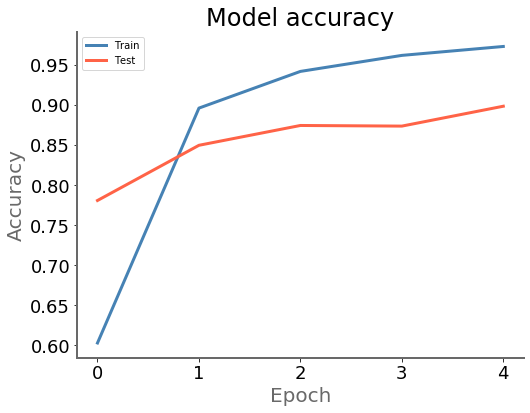

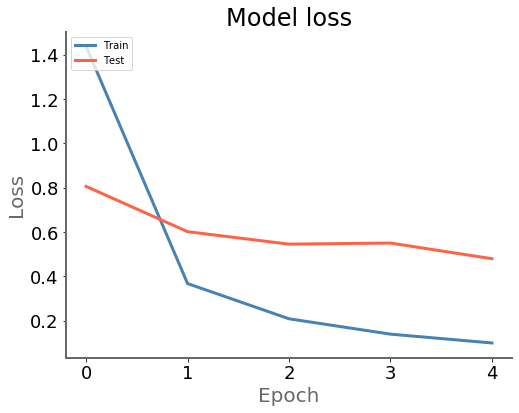

In [27]:
ooo.plot_history(history)

---
### Results :  
L25 : size=250 Mo, 93.15%  
...